In [1]:
import numpy as np # библиотека работы с массивами
import pandas as pd # библиотека для работы с базами
import seaborn as sns # работа с графиками

from tensorflow.keras.models import Sequential, Model, load_model # последовательная и функциональная модели
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop # оптимайзеры
from tensorflow.keras.preprocessing.text import Tokenizer # преобразование текстов в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # дополнить нулями вектор
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # подключаем колбэки
from tensorflow.keras.metrics import Precision, Recall # метрики

from sklearn.cluster import KMeans, AgglomerativeClustering # Импортируем библиотeку KMeans для кластеризации и Иерархическую кластеризацию
from scipy.cluster.hierarchy import dendrogram, linkage # классыы для кластеризации Иерархической кластеризации

from sklearn.preprocessing import LabelEncoder, StandardScaler # перевод в категориальные данные и стандартизация данных
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from tensorflow.keras.utils import plot_model, to_categorical # вывод схемы модели
import pickle                   # для загрузки-сохранения обьектов
import matplotlib.pyplot as plt # для графиков
import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")  # 'ignore'   Никогда не печатать соответствующие предупреждения
sns.set_style('darkgrid')

# Предобработка, создание енкодеров и токенайзеров

In [2]:
# функция сохранения объекта
def save_obj(obj_to_save, filename):
  with open(filename, 'wb') as f:
    pickle.dump(obj_to_save, f, protocol=pickle.HIGHEST_PROTOCOL) # saving
    
# функция загрузки обьекта
def load_obj(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f) # loading
    
# категориальные и числовые столбцы
object_cols = ['district', 'street', 'house_floor', 'planning', 'rooms']
numeric_cols = ['area1', 'area2', 'price']
text_cols = ['comment']
all_cols = object_cols + numeric_cols + text_cols

In [3]:
# прочитаем файл
df = pd.read_csv('http://m.ufamax.eu:8080/belka/citystar-parsed.csv') # загружаем со своего сервера
df.head()

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...
1,Орджоникидзевский,50-летия Магнитки,3,нестандартная,3,98.5,60.0,6990,Продам трехкомнатную квартиру 100кв.м. Простор...
2,Ленинский,Менделеева,3,старой планировки,3,83.0,55.0,5100,ПРОДАМ трехкомнатную квартиру старой планировк...
3,Правобережный,Ленина пр-т,7,малосемейка,1,30.4,17.0,1790,Квартира малосемейка в хорошем состоянии. П...
4,Ленинский,Ленина пр-т,5,-,3,77.0,48.0,3990,КВАРТИРА СТАРОЙ ПЛАНИРОВКИ С ВЫСОКИМИ ПОТОЛКА...


In [ ]:
# посмотрим структуру и типы столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district     880 non-null    object 
 1   street       874 non-null    object 
 2   house_floor  880 non-null    int64  
 3   planning     880 non-null    object 
 4   rooms        880 non-null    int64  
 5   area1        880 non-null    float64
 6   area2        880 non-null    float64
 7   price        880 non-null    int64  
 8   comment      880 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.0+ KB


In [ ]:
# проходим LabelEncoder по категориальным данным
for col in object_cols:
  le = LabelEncoder() # создаем енкодер для категорий
  le.fit(df[col].astype(str)) # обучаем 
  save_obj(le, col) # сохраним энкодер для столбца

In [ ]:
# проходим StandardScaler по числовым данным
for col in numeric_cols:
  ss = StandardScaler() # создаём нормировщик нормальным распределением
  ss.fit(df[col].values.reshape(-1,1)) # обучаем
  save_obj(ss, col) # сохраним энкодер для столбца

In [ ]:
# создаем токенайзер и обучаем его на всех комментариях
tokenizer = Tokenizer(num_words=10000, # количество слов для словаря # в базе 6778 слов
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # фильтр текста
                      lower=True, # нижний регистр
                      split=' ', # разделить пробелом
                      oov_token='unknown', # обозначим слова вне словаря
                      char_level=False # токенизируем по словам
                      )
tokenizer.fit_on_texts(df['comment'].tolist()) # обучаем и проходим по обучающей выборке
save_obj(tokenizer, 'comment') # сохраним токенайзер

# Загрузка данных

In [ ]:
# загрузим все LabelEncoder и StandardScaler
district = load_obj('district')
street = load_obj('street')
house_floor = load_obj('house_floor')
planning = load_obj('planning')
rooms = load_obj('rooms')
area1 = load_obj('area1')
area2 = load_obj('area2')
price = load_obj('price')
# загрузим токенайзер
tokenizer = load_obj('comment')

In [ ]:
# взглянем на исходные данные еще раз
df.head(1)

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...


In [ ]:
# a = district.transform([ df['district'][0] ])[0]
# print(a)

# nClasses = len(district.classes_)
# b = to_categorical(a, nClasses)
# print(list(b))

In [ ]:
# a = area1.transform(np.array( df['area1'][0] ).reshape(-1,1))[0][0]
# a

In [ ]:
# a = tokenizer.texts_to_sequences([ df['comment'][0] ])[0]
# print(a)

# b = tokenizer.sequences_to_matrix([ a ])[0]
# print(b)

In [ ]:
########## категориальные данные ############

# функция преобразования района в формат One-Hot Encoding
def pack_district(d):
  d = str(d) # конвертирум в строку
  t = district.transform([ d ])[0] # берем категорию
  n = len(district.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования улицы в формат One-Hot Encoding
def pack_street(d):
  d = str(d) # конвертирум в строку
  t = street.transform([ d ])[0] # берем категорию
  n = len(street.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования этажа в формат One-Hot Encoding
def pack_house_floor(d):
  d = str(d) # конвертирум в строку
  t = house_floor.transform([ d ])[0] # берем категорию
  n = len(house_floor.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования планировки в формат One-Hot Encoding
def pack_planning(d):
  d = str(d) # конвертирум в строку
  t = planning.transform([ d ])[0] # берем категорию
  n = len(planning.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования комнат в формат One-Hot Encoding
def pack_rooms(d):
  d = str(d) # конвертирум в строку
  t = rooms.transform([ d ])[0] # берем категорию
  n = len(rooms.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

########## числовые данные ############

# функция преобразования area1 в формат 
def pack_area1(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = area1.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

# функция преобразования area2 в формат 
def pack_area2(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = area2.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

# функция преобразования price в формат 
def pack_price(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = price.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

########## текстовые данные ############

# функция преобразования текста в вектор Bag-of-Words
def pack_comment(d):
  d = str(d) # конвертирум в строку
  t = tokenizer.texts_to_sequences([ d ])[0] # превращаем слова в токены
  l = tokenizer.sequences_to_matrix([ t ])[0] # превращаем в вектор BoF
  return list(l) # вовзращаем списком вектор BoF

# функция сборки вектора для модели
def get_all_parameters(*args):
  out = [] # здесь будут все параметры в ряд
  for c in args:
    if isinstance(c, float) or isinstance(c, int):
      out.append(c) # добавить append в список
    if isinstance(c, list):
      out.extend(c) # дополнить extend список
  return out # вернем список

# функция предикта 
def get_district(model, scale, street, house_floor, planning, rooms, area1, area2, price, comment):
  # собираем входные данные с помощью get_all_parameters()
  x_data = [get_all_parameters(pack_street(street),\
                               pack_house_floor(house_floor),\
                               pack_planning(planning),\
                               pack_rooms(rooms),\
                               pack_area1(area1),\
                               pack_area2(area2),\
                               pack_price(price),\
                               pack_comment(comment))]
  x_data = np.array(x_data) # переводим в numpy
  if scale: # если нужно применить стандартизацию
    x_data = ClusterScaler.transform(x_data)
  pred = model.predict(x_data) # делаем прогноз
  return ClusterAnswers[pred[0]]

In [ ]:
# взглянем на исходные данные еще раз
df.head(40)

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...
1,Орджоникидзевский,50-летия Магнитки,3,нестандартная,3,98.5,60.0,6990,Продам трехкомнатную квартиру 100кв.м. Простор...
2,Ленинский,Менделеева,3,старой планировки,3,83.0,55.0,5100,ПРОДАМ трехкомнатную квартиру старой планировк...
3,Правобережный,Ленина пр-т,7,малосемейка,1,30.4,17.0,1790,Квартира малосемейка в хорошем состоянии. П...
4,Ленинский,Ленина пр-т,5,-,3,77.0,48.0,3990,КВАРТИРА СТАРОЙ ПЛАНИРОВКИ С ВЫСОКИМИ ПОТОЛКА...
5,Орджоникидзевский,Жукова,5,-,2,49.8,29.3,3150,Продам 2-комнатную квартируbrв Орджоникидзевск...
6,Правобережный,Лесопарковая,5,брежневка,2,44.0,27.0,2600,"Тихий, богатый озеленением район города! Удачн..."
7,Орджоникидзевский,Калмыкова,9,свердловский вариант,3,64.0,40.0,4290,Описание КВАРТИРА С ОТЛИЧНЫМ КАПИТАЛЬНЫМ РЕМО...
8,Орджоникидзевский,Доменщиков,2,брежневка,2,45.2,30.0,2900,Продам двухкомнатную квартиру в хорошем состоя...
9,Правобережный,Суворова,1,-,3,55.7,38.0,3350,"Продам квартиру, в которой все черновые работы..."


In [ ]:
# собираем входные данные с помощью get_all_parameters()
x_data = [get_all_parameters(pack_street(df.loc[i,'street']),\
                             pack_house_floor(df.loc[i,'house_floor']),\
                             pack_planning(df.loc[i,'planning']),\
                             pack_rooms(df.loc[i,'rooms']),\
                             pack_area1(df.loc[i,'area1']),\
                             pack_area2(df.loc[i,'area2']),\
                             pack_price(df.loc[i, 'price']),\
                             pack_comment(df.loc[i,'comment']))\
          for i in range(len(df))]
x_data = np.array(x_data)

# собираем выходные данные с помощью get_all_parameters()
y_data = [pack_district(df.loc[i,'district']) for i in range(len(df))]
y_data = np.array(y_data)

print(f'x_data: {x_data.shape}')
print(f'y_data: {y_data.shape}')

x_data: (880, 10182)
y_data: (880, 6)


# Кластеризация

## Метод KMean

In [ ]:
# делаем стандартизацию данных перед кластеризацией
ClusterScaler = StandardScaler() # создаем скалер
x_data_scaled = ClusterScaler.fit_transform(x_data)

In [ ]:
clustersCount = 30            # Указываем количество кластеров
kmean = KMeans(clustersCount) # создаем объект KMeans
kmean.fit(x_data)     # обучаем объект кластеризации
labels = kmean.labels_        # получим метки кластеров
print(labels)                 # выведем метки кластеров

[ 9  1  1  9  4  4 14  4  9  4  4  4  4  9  1  9  9  9  4  9  4  9  9  4
  9  9  1  9  9  9  9  9  4  4  9  9  4  9  4  9  9  9  9  4  9  4  9  9
  9  4  4  7  9  0  4  4  9  9  4  9  4  0 21  0 16  0  9  1  9  9  9  9
  1  4  1  9  1  4  9  1 26  9  9  9  4  9  1  1  4  4  9  1 26  4 16  1
  1  4  4  0  0  4  1  4  9  9  0  1  9  1  9  1  4  1  9  9  9  4  9  9
  9  9  9  9  9  9 16 16  9  9  1  4  3 10  9  9  9  1  1  9  9  1  9  4
  9  9  4  9  9  4  9  4  9  9  9 16 16  9  9  4  4 16 16  4  9  4  9  9
  9  1  4 16 16 21  9  4  9  3  9  4 24  9  1  4  9  9  9  9  1 13  9 13
  9  9  4  9  9  4 16 16 14  9  4  9  9 14  4  4  4  9  9  9  9  9  1 26
  4  9  9  4  9  4  9  9  9 16 16  4  9  9 16 16  9  9  1  4  4  9 26  9
  1  4  4  9  1  4  9 16 16  4  4  4  1  9  9  1  4  9  4  4  4  9  9  9
 16 16  9  9  1  9 16 16  9  4  4  9  4  4  4  9  4  9  9  9  1  8  4  4
  9  9  4  1  9  4  4  9 16 16  4  0  9  9  4  9  1  4  4  1  4  4  9  9
  9  9  1  9 16 16  4  4  9  4  4  9  9  9  9  4  4

In [ ]:
ClusterAnswers = {} # созадим словарь в котором будут соответствия кластеров и названия районов
for clusterNumber in range(clustersCount): # пройдем по кластерам
  ClusterAnswers[clusterNumber] = df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]

for clusterNumber in range(clustersCount):
  print( f"Имя самого частого района в кластере: \t\t{df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]}" )
  print( f"Качество попадания этого района в кластер: \t{round(df.loc[labels==clusterNumber,:]['district'].value_counts()[0] / len(df[df['district']==df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]]),2)}" )

Имя самого частого района в кластере: 		-
Качество попадания этого района в кластер: 	0.08
Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.1
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 	0.03
Имя самого частого района в кластере: 		Правобережный
Качество попадания этого района в кластер: 	0.05
Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.26
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 	0.03
Имя самого частого района в кластере: 		Правобережный
Качество попадания этого района в кластер: 	0.05
Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.0
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 	0.01
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кла

In [ ]:
print('Верный ответ: ', 'Ленинский')
print('Прогноз: ', get_district(kmean, False,
                  'Куйбышева', '1', 'раздельная', '3', '57', '35', '2850',\
                  'Трехкомнатная квартира нестандартной планировки (третья комната с отдельным входом) в нормальном состоянии, санузел раздельный,'
                  ' трубы пластиковые, водомеры. Первый этаж, высоко. В центре Ленинского района. Есть все: садики, школы, скверы и парки, магазины,'
                  ' поликлиника. Очень тихое, спокойное место.') )
print()
print('Верный ответ: ', 'Орджоникидзевский')
print('Прогноз: ', get_district(kmean, False,
                  '50-летия Магнитки', '3', 'нестандартная', '3', '98.5', '60', '6990',\
                  'Продам трехкомнатную квартиру 100кв.м. Просторная,светлая,уютная- встроенные удобные гардеробные, два больших балкона, кондиционер,'
                  ' водонагреватель, раздельный санузел, видео- звонок. Во дворе дома детский сад и школа. Остается мебель и кухонный гарнитур. '
                  'В собственности более 5 лет. Долгов и обременений нет.Один собственник.') )
print()
print('Верный ответ: ', 'Правобережный')
print('Прогноз: ', get_district(kmean, False,
                  'Ленина пр-т', '7', 'малосемейка', '1', '30.4', '17', '1790',\
                  'Квартира малосемейка в хорошем состоянии. Пластиковые окна, потолки выровнены побелены, на полу линолиум.'
                  'Двери межкомнатные поменяны, входная дверь металлическая. В смежном санузле кафель, пластиковые трубы. '
                  'Балкон не застеклён. Окна выходят на восток, квартира очень тёплая, светлая. Дом расположен в центре города. '
                  'Рядом остановка маршруток, магазины,аптеки. Во дворе 3 детских садика, школа 66. Детям безопасно, дорогу переходить не нужно. '
                  'Рядом улицы Советской Армии, Грязнова. Чистая продажа, документы готовы. Поможем продать Вашу недвижимость по лучшей цене, оформить'
                  ' выгодную ипотеку, удачно применить Материнский капитал. Звоните!') )
print()
print('Верный ответ: ', 'Орджоникидзевский (левый берег)')
print('Прогноз: ', get_district(kmean, False,
                  'Лазника', '3', 'нестандартная', '1', '43', '22', '2300',\
                  'Пластиковые окна, трубы, лоджия застеклена, ж/д, м/д. Имеется свое парковочное место.Состояние отличное.') )
print()
print('Верный ответ: ', 'Ленинский (левый берег)')
print('Прогноз: ', get_district(kmean, False,
                  'Тарасенко', '3', 'смежная', '2', '42', '27', '1950',\
                  'Продается очень теплая, светлая, уютная двухкомнатная квартира. Комнаты смежные. Квартира готова для проживания. '
                  'Окна пластиковые, балкон застеклен пластиком, потолки в комнатах натяжные, на полу ленолиум. Во дворе большая детская площадка. '
                  'Есть места для парковки автомашины. Тихие дружелюбные соседи. Не далеко два детских садика. Реальному покупателю торг!!!'
                  ' Рассмотрю варианты обмена на однокомнатную квартиру на правом берегу') )
print()

Верный ответ:  Ленинский
Прогноз:  Ленинский

Верный ответ:  Орджоникидзевский
Прогноз:  Орджоникидзевский

Верный ответ:  Правобережный
Прогноз:  Ленинский

Верный ответ:  Орджоникидзевский (левый берег)
Прогноз:  Ленинский

Верный ответ:  Ленинский (левый берег)
Прогноз:  Ленинский



## Найдем оптимальное количество кластеров (Метод локтя)

Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
Готово разбиение на 13 классов
Готово разбиение на 14 классов
Готово разбиение на 15 классов
Готово разбиение на 16 классов
Готово разбиение на 17 классов
Готово разбиение на 18 классов
Готово разбиение на 19 классов
Готово разбиение на 20 классов
Готово разбиение на 21 классов
Готово разбиение на 22 классов
Готово разбиение на 23 классов
Готово разбиение на 24 классов
Готово разбиение на 25 классов
Готово разбиение на 26 классов
Готово разбиение на 27 классов
Готово разбиение на 28 классов
Готово разбиение на 29 классов


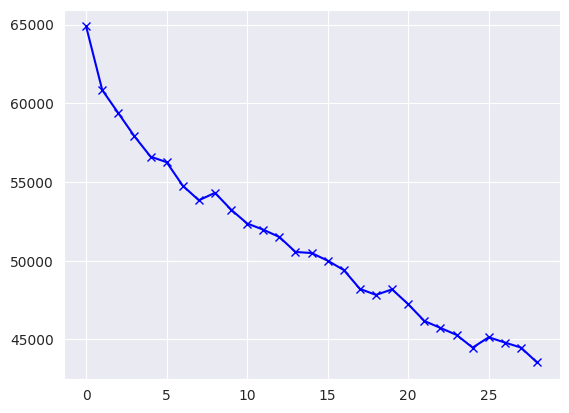

In [ ]:
cost = []
for i in range(1,30):
  kmean = KMeans(i)
  kmean.fit(x_data)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i, " классов", sep="")
    
plt.plot(cost, 'bx-')

**Оптимальное количество кластеров 7,10,15,20,27 (значение по графику +1, т.к. на графике отсчет от 0)**

## Иерархическая кластеризация

In [ ]:
clustersCount = 30  # Указываем количество кластеров
cluster = AgglomerativeClustering(n_clusters=clustersCount, affinity='euclidean', linkage='ward')  # Создаем объект AgglomerativeClustering
cluster.fit(x_data) # обучаем модель
labels = cluster.labels_ # метки классов
labels

array([ 2,  5,  5,  5,  5,  5, 11,  5,  5,  5,  5,  5,  7,  2,  5,  2,  2,
        2,  5,  0,  5,  5,  2,  5,  5,  2,  2,  5,  2,  2,  2,  5,  5,  5,
        5,  2,  5,  2,  5,  5,  2,  2,  5,  5,  2,  5,  5,  2,  2,  5,  5,
        5,  5,  4,  5,  5,  2,  2,  5,  2,  4,  4,  5,  4, 23,  4,  2, 10,
        2,  2,  5,  2,  5,  5,  5,  2,  5,  5,  2, 10, 11,  2,  2,  5,  5,
        5, 10, 10,  5,  5,  2,  2, 11,  5, 23, 10, 10,  7,  5,  4,  4,  5,
       10,  2,  2,  2,  4, 10,  2, 10,  2, 10,  5, 10,  2,  2,  5,  5, 22,
        5,  2, 22,  5, 22,  2,  2, 23, 23,  2,  2, 10,  2,  3,  3,  2,  2,
        5, 10, 10,  5,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,
        2,  5, 23, 23,  2,  2,  5,  5, 23, 23,  5,  2,  5,  2,  2,  2,  2,
        5, 23, 23,  5,  2,  5,  5,  3,  2,  5, 18,  2,  5,  5,  5,  2,  2,
        2, 10,  1,  2,  1,  5,  2,  5,  5,  2,  5, 23, 23, 11,  2,  5,  5,
        2, 11,  5,  5,  5,  2,  2,  2,  2,  2,  5, 11,  5,  2,  2,  2,  2,
        2,  5,  2,  2, 23

In [ ]:
ClusterAnswers = {} # созадим словарь в котором будут соответствия кластеров и названия районов
for clusterNumber in range(clustersCount): # пройдем по кластерам
  ClusterAnswers[clusterNumber] = df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]

for clusterNumber in range(clustersCount):
  print( f"Имя самого частого района в кластере: \t\t{df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]}" )
  print( f"Качество попадания этого района в кластер: \t{round(df.loc[labels==clusterNumber,:]['district'].value_counts()[0] / len(df[df['district']==df.loc[labels==clusterNumber,:]['district'].value_counts().index[0]]),2)}" )

Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.04
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 	0.06
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 	0.31
Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.04
Имя самого частого района в кластере: 		-
Качество попадания этого района в кластер: 	0.08
Имя самого частого района в кластере: 		Орджоникидзевский
Качество попадания этого района в кластер: 	0.33
Имя самого частого района в кластере: 		Правобережный
Качество попадания этого района в кластер: 	0.05
Имя самого частого района в кластере: 		-
Качество попадания этого района в кластер: 	0.03
Имя самого частого района в кластере: 		Правобережный
Качество попадания этого района в кластер: 	0.08
Имя самого частого района в кластере: 		Ленинский
Качество попадания этого района в кластер: 

In [ ]:
index0=df[df['district']=='Ленинский'].index[0] # берем строку # Ленинский
clusterNumber=labels[index0] # номер кластера под которым она определилась
print('Верный ответ: ', df.loc[index0, 'district'] ) # какой это район в обучаемой выборке
print('Прогноз: ', df.loc[labels==clusterNumber,:]['district'].value_counts().index[0] ) # самое частое значение в этом кластере - оно будет предиктом
print()

index0=df[df['district']=='Орджоникидзевский'].index[0] # берем строку # Орджоникидзевский
clusterNumber=labels[index0] # номер кластера под которым она определилась
print('Верный ответ: ', df.loc[index0, 'district'] ) # какой это район в обучаемой выборке
print('Прогноз: ', df.loc[labels==clusterNumber,:]['district'].value_counts().index[0] ) # самое частое значение в этом кластере - оно будет предиктом
print()

index0=df[df['district']=='Правобережный'].index[0] # берем строку # Правобережный
clusterNumber=labels[index0] # номер кластера под которым она определилась
print('Верный ответ: ', df.loc[index0, 'district'] ) # какой это район в обучаемой выборке
print('Прогноз: ', df.loc[labels==clusterNumber,:]['district'].value_counts().index[0] ) # самое частое значение в этом кластере - оно будет предиктом
print()

index0=df[df['district']=='Орджоникидзевский (левый берег)'].index[0] # берем строку # Орджоникидзевский (левый берег)
clusterNumber=labels[index0] # номер кластера под которым она определилась
print('Верный ответ: ', df.loc[index0, 'district'] ) # какой это район в обучаемой выборке
print('Прогноз: ', df.loc[labels==clusterNumber,:]['district'].value_counts().index[0] ) # самое частое значение в этом кластере - оно будет предиктом
print()

index0=df[df['district']=='Ленинский (левый берег)'].index[0] # берем строку # Ленинский (левый берег)
clusterNumber=labels[index0] # номер кластера под которым она определилась
print('Верный ответ: ', df.loc[index0, 'district'] ) # какой это район в обучаемой выборке
print('Прогноз: ', df.loc[labels==clusterNumber,:]['district'].value_counts().index[0] ) # самое частое значение в этом кластере - оно будет предиктом
print()

Верный ответ:  Ленинский
Прогноз:  Ленинский

Верный ответ:  Орджоникидзевский
Прогноз:  Орджоникидзевский

Верный ответ:  Правобережный
Прогноз:  Орджоникидзевский

Верный ответ:  Орджоникидзевский (левый берег)
Прогноз:  Ленинский

Верный ответ:  Ленинский (левый берег)
Прогноз:  Ленинский



In [ ]:
# получаем таблицу связок обьектов по расстояниям
linked = linkage(x_data, method = 'ward') 

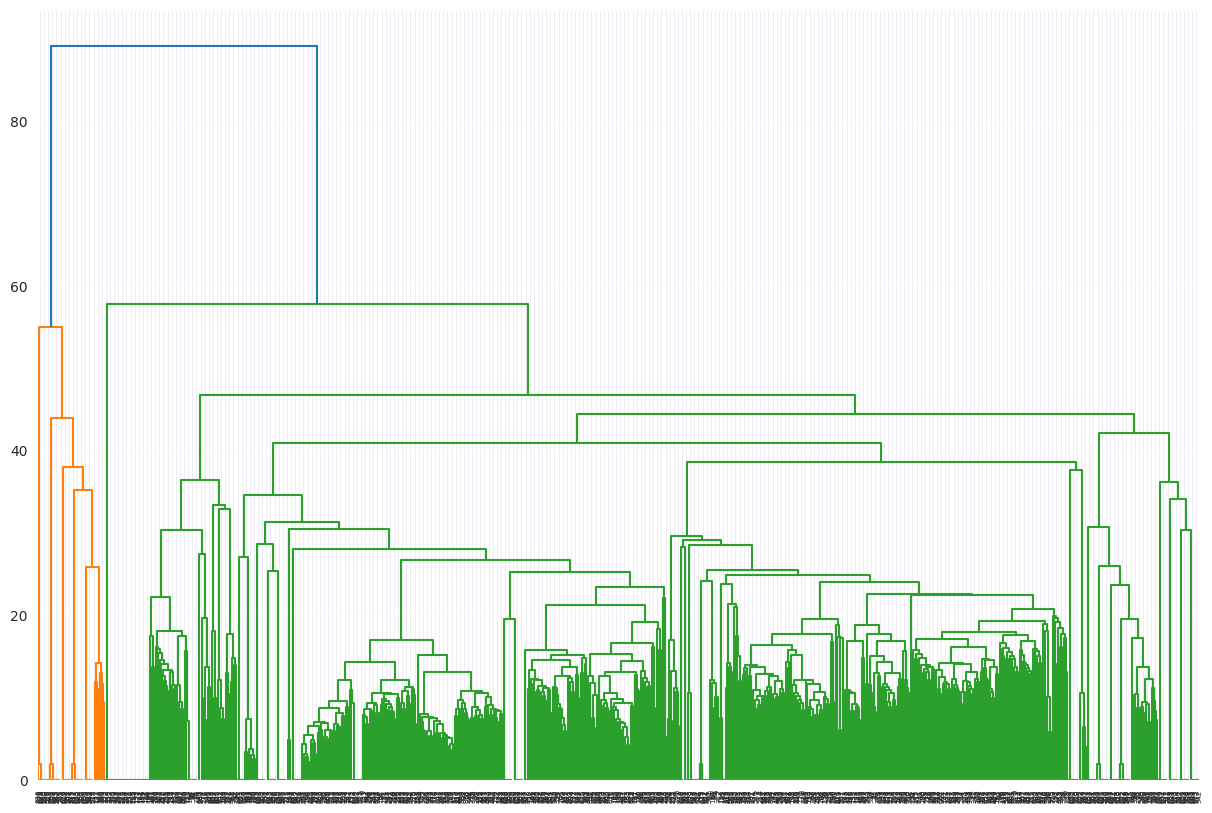

In [ ]:
# построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 